## A Hierarchical Bayesian Framework for Stellar Obliquity Distribution Inference

**Jiayin Dong**<sup>1</sup> and **Dan Foreman-Mackey**<sup>1</sup>

<sup>1</sup>CCA, Flatiron Institute

February 2023

Jupyter Notebook demonstration for Dong & Foreman-Mackey 2023 to be submitted to the AAS Journals

---

In this notebook, we present a few cases to apply the hierarchical Bayesian model (HBM) described in Dong & Foreman-Mackey 2023 to infer the stellar obliquity $\psi$ distribution of a sample.

Cases:
1. Infer the $\psi$ distribution from $\lambda$ only
2. Infer the $\psi$ distribution from $\lambda$ and $i_\star$
3. Infer the $\psi$ distribution from $\lambda$, $R_\star$, $P_{\rm rot}$, and $v\sin{i_\star}$

You will soon find that, with each dataset, the underlying stellar obliquity distribution can be correctly inferred.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor.tensor as at
import pytensor

from matplotlib import rc
rc('font', **{'family':'sans-serif'})
rc('text', usetex=True)

In [2]:
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('pymc', pm.__version__)
print('arviz', az.__version__)
print('pytensor', pytensor.__version__)

numpy 1.24.2
pandas 1.5.3
pymc 5.1.2
arviz 0.15.1
pytensor 2.10.1


In [3]:
np.random.seed(123)

Let's first generate some data for this demonstration. 
Assume that we have 200 planetary systems. Among them, 
- 70% of the systems are well aligned with stellar obliquities $\psi$ less than 30$^\circ$
- 30% of the systems are misaligned with stellar obliquities $\psi$ isotropically distributed 

In $\cos{\psi}$ space, this corresponds to

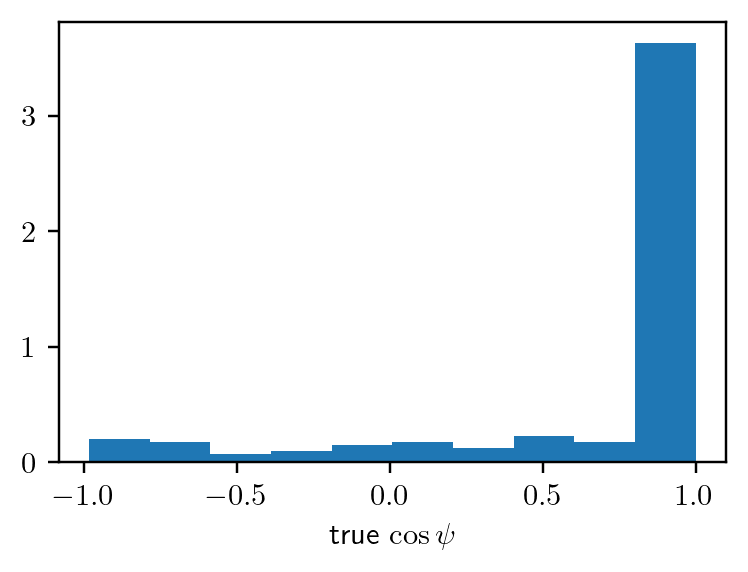

In [4]:
nsample = 200

pop_a = np.random.uniform(np.cos(30*np.pi/180), 1, int(nsample*0.7))
pop_m = np.random.uniform(-1, 1, int(nsample*0.3))
true_cosψ = np.append(pop_a, pop_m)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_cosψ, density=True, bins=10)
plt.xlabel(r'true $\cos{\psi}$')
plt.tight_layout()
plt.show()

Assume the azimuthal angle between the stellar spin axis and orbital axis, $\theta$, is uniformly distributed between $[0, \pi]$.

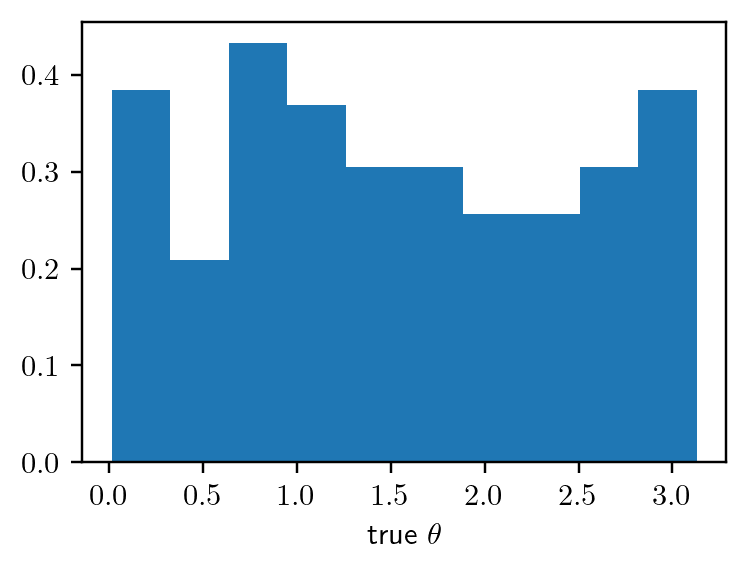

In [5]:
true_θ = np.random.uniform(0., np.pi, nsample)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_θ, density=True, bins=10)
plt.xlabel(r'true $\theta$')
plt.tight_layout()
plt.show()

Assume the cosine of the orbital inclination is uniformly distributed, such that $\lvert \cos{i_{\rm orb}}\rvert < R_\star/a$. Here we use an $a/R_\star$ of 5 and assume $i_{\rm orb} \leq \pi/2$.

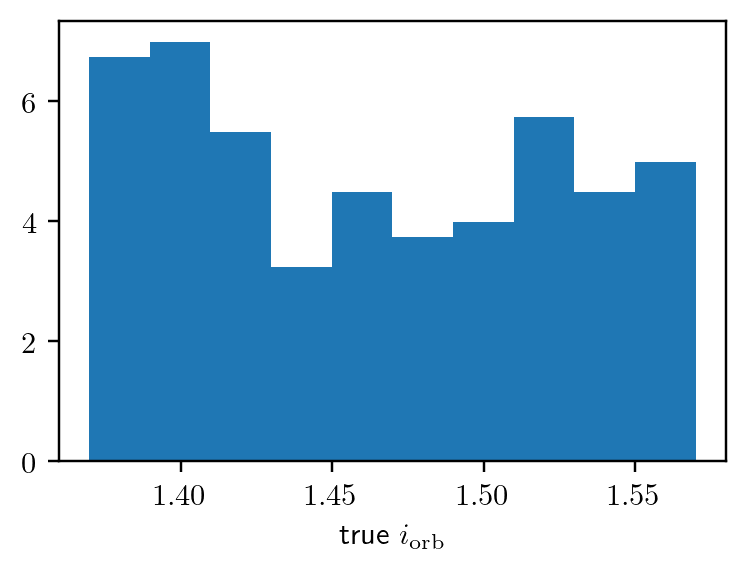

In [10]:
true_cosiorb = np.random.uniform(0., 0.2, nsample)
true_iorb = np.arccos(true_cosiorb)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_iorb, density=True, bins=10)
plt.xlabel(r'true $i_{\rm orb}$')
plt.tight_layout()
plt.show()

From $\psi$, $\theta$, and $i_{\rm orb}$, we could now calculate the corresponding sky-projected stellar obliquities $\lambda$ and stellar inclinations $i_\star$.

In [11]:
true_sinψ = np.sqrt(1-true_cosψ**2)
true_sinθ = np.sin(true_θ)
true_cosθ = np.cos(true_θ)

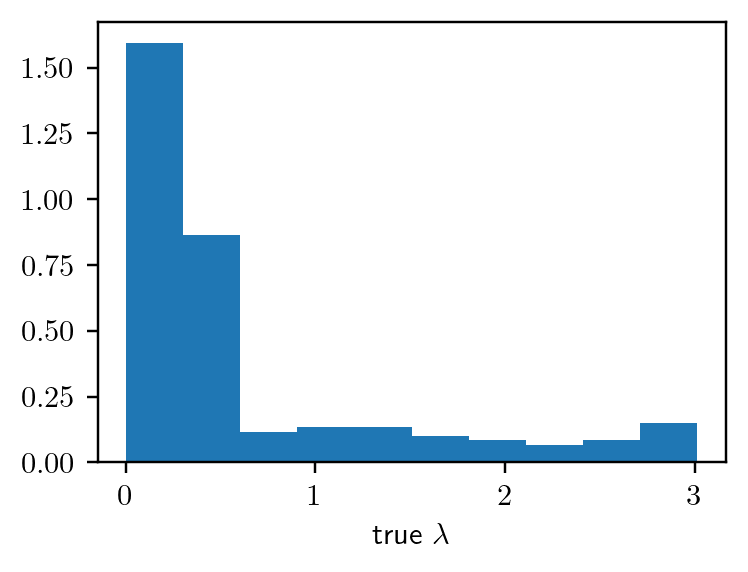

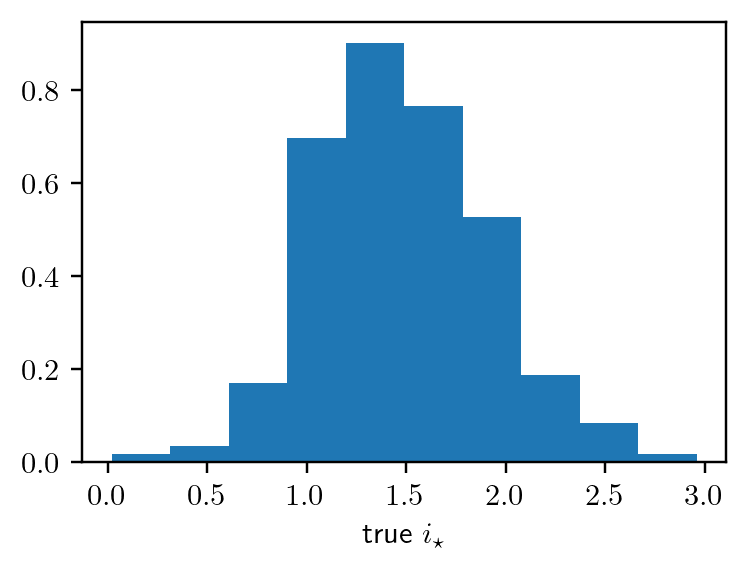

In [12]:
true_lam = np.arctan2(true_sinψ*true_sinθ, true_cosψ*np.sin(true_iorb)-true_sinψ*true_cosθ*np.cos(true_iorb))

true_istar = np.arccos(true_sinψ*true_cosθ*np.sin(true_iorb)+true_cosψ*np.cos(true_iorb))

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_lam, density=True, bins=10)
plt.xlabel(r'true $\lambda$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_istar, density=True, bins=10)
plt.xlabel(r'true $i_\star$')
plt.tight_layout()
plt.show()

We now add some Gaussian noise to simulate observed lambda, stellar inclination, and orbital inclination values. We assume $\sigma_{i_\star} = 10^\circ$, $\sigma_\lambda = 8^\circ$, and $\sigma_{i_{\rm orb}} = 1^\circ$.

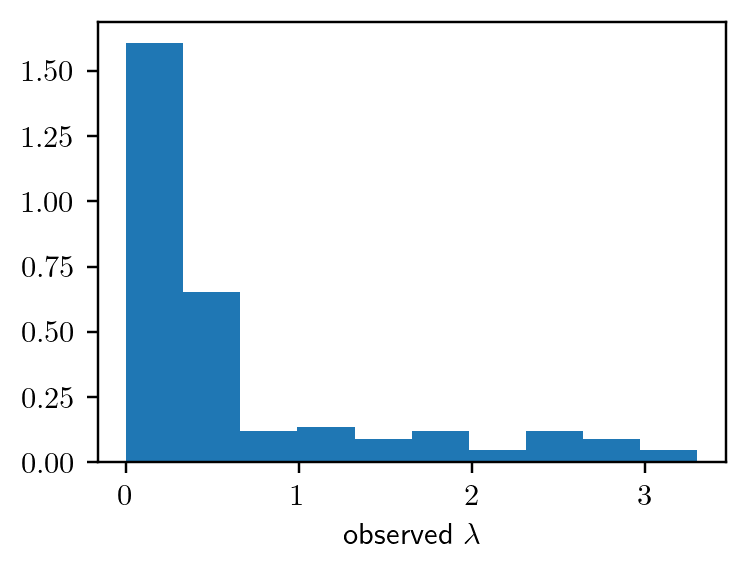

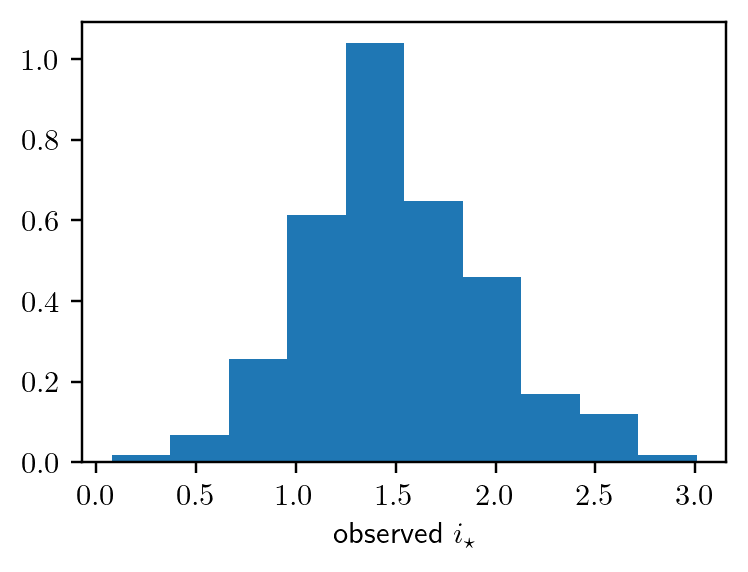

In [13]:
# Add some Gaussian noises
err_istar = 10*np.pi/180
err_lam = 8*np.pi/180
err_iorb = 1*np.pi/180

obs_istar = true_istar + err_istar*np.random.normal(size=nsample)
obs_lam = true_lam + err_lam*np.random.normal(size=nsample)
obs_iorb = true_iorb + err_iorb*np.random.normal(size=nsample)

# Limit obs_lam to [0, pi]
obs_lam[obs_lam<0] = -obs_lam[obs_lam<0]

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_lam, density=True, bins=10)
plt.xlabel(r'observed $\lambda$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_istar, density=True, bins=10)
plt.xlabel(r'observed $i_\star$')
plt.tight_layout()
plt.show()

If the rotational modulation method is used to infer $i_\star$, we instead measure the rotation period of the star $P_{\rm rot}$, radius of the star $R_\star$, and projected rotation velocity of the star $v\sin{i_\star}$.
We now simulate these observables.

First, we find the *true* values.

Assume the rotation period $P_{\rm rot} \sim {\rm Uniform}(3,20)$ in days and $R_\star \sim \mathcal{N}(1,0.1)$ in $R_\odot$ for $\mathcal{N}(\mu,\sigma)$.

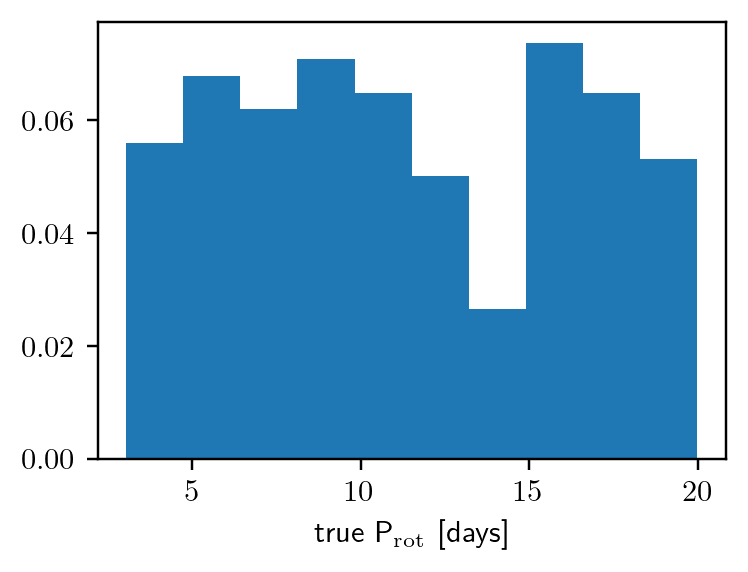

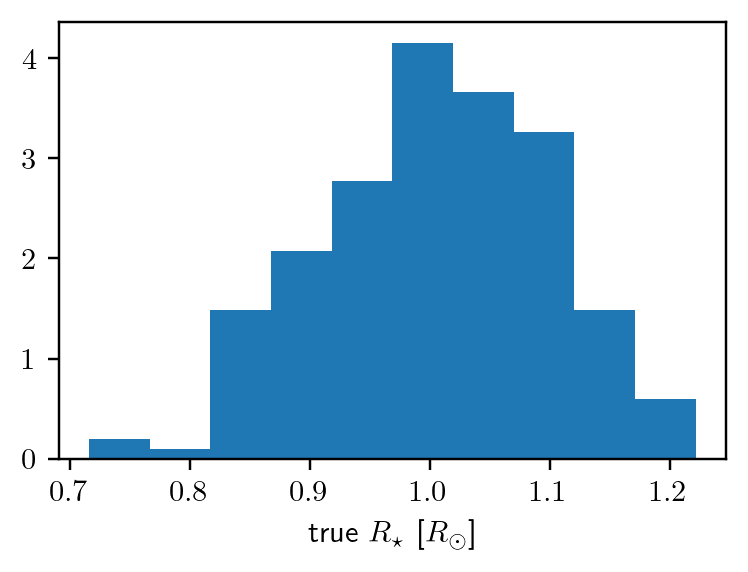

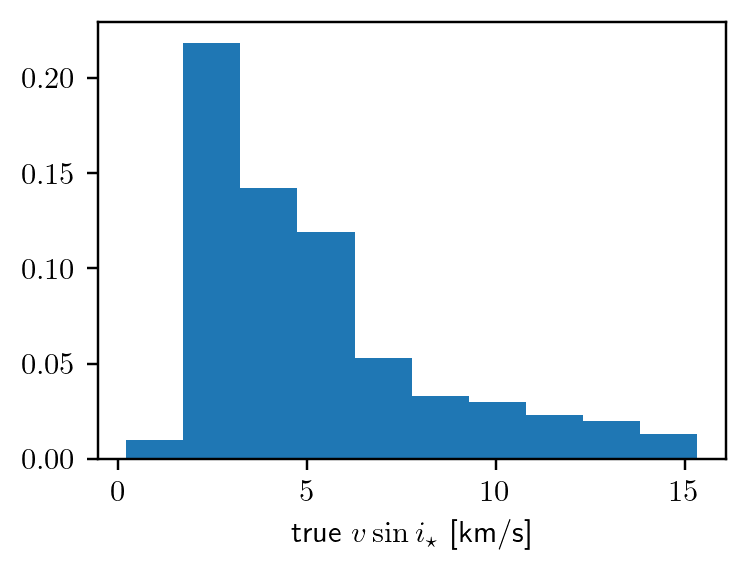

In [14]:
true_Prot = np.random.uniform(3, 20, nsample)
true_Rstar = np.random.normal(1, 0.1, nsample)
true_vrot = 2*np.pi*true_Rstar/true_Prot*8.052 # normalization (1 solar radii)/(1 day) in km/s
true_vsini = true_vrot*np.sin(true_istar)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_Prot, density=True, bins=10)
plt.xlabel(r'true P$_{\rm rot}$ [days]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_Rstar, density=True, bins=10)
plt.xlabel(r'true $R_\star$ [$R_\odot$]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_vsini, density=True, bins=10)
plt.xlabel(r'true $v\sin{i_\star}$ [km/s]')
plt.tight_layout()
plt.show()

Now add some Gaussian noise to these values.

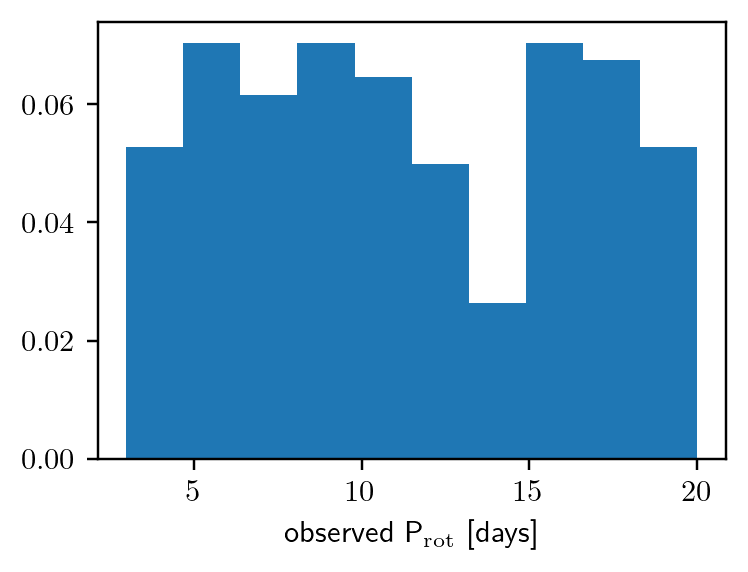

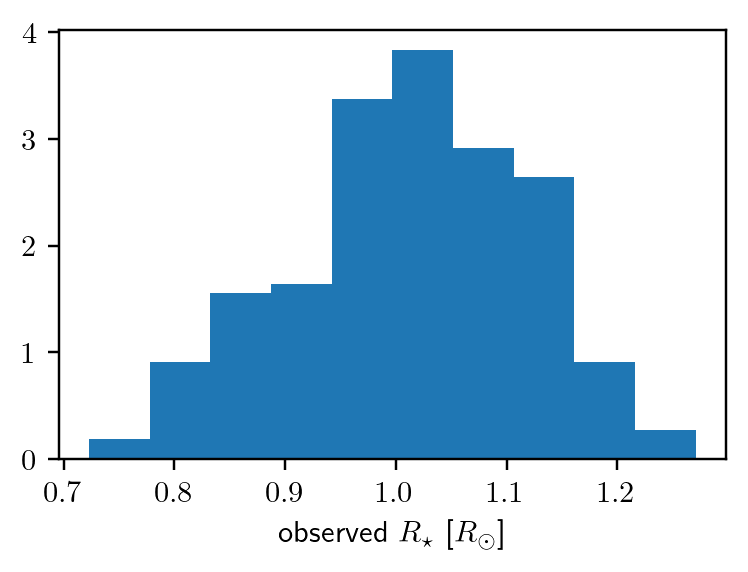

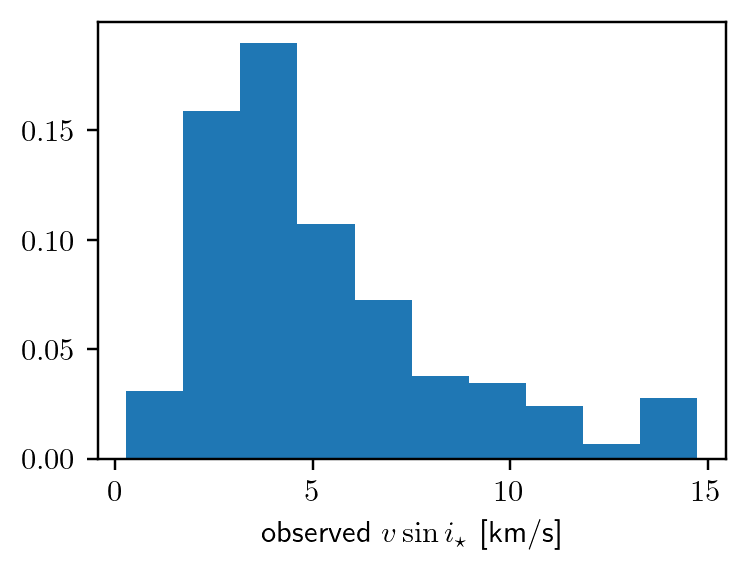

In [15]:
err_Rstar = 0.05  # Rsun
err_Prot = 0.1  # days
err_vsini = 0.5  # km/s

# Add some Gaussian noises
obs_Rstar =true_Rstar + err_Rstar*np.random.normal(size=nsample)
obs_Prot = true_Prot + err_Prot*np.random.normal(size=nsample)
obs_vsini = true_vsini + err_vsini*np.random.normal(size=nsample)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_Prot, density=True, bins=10)
plt.xlabel(r'observed P$_{\rm rot}$ [days]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_Rstar, density=True, bins=10)
plt.xlabel(r'observed $R_\star$ [$R_\odot$]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_vsini, density=True, bins=10)
plt.xlabel(r'observed $v\sin{i_\star}$ [km/s]')
plt.tight_layout()
plt.show()

With these simulated data, we are ready for the stellar obliquity inference.

### Case 1: Infer the $\psi$ distribution from $\lambda$

In this model, we infer the stellar obliquity distribution only from sky-projected stellar obliquity measurements obs_lam and err_lam. No stellar inclination measurement is required. 

The two-component stellar obliquity distribution is described as 

$w_{0,1} \sim {\rm Dirichlet}(1, 1)$

$u_{0,1} \sim {\rm Beta}(\mu_{0,1}\kappa_{0,1}, (1-\mu_{0,1})\kappa_{0,1})$

$\cos{\psi} \sim 2\,(w_0 u_0 + w_1 u_1) - 1$

where $w_0, w_1, \mu_0, \kappa_0, \mu_1, \kappa_1$ will be inferred. 

Input:
- obs_lam, err_lam
- obs_iorb, err_iorb

Output:
- Inferred $\psi$ for each planet
- Inferred $\{w_0, w_1, \mu_0, \kappa_0, \mu_1, \kappa_1\}$ that describe the stellar obliquity $\psi$ distribution

According to our injected fucntion, the fraction of misaligned population $w_0$ should be close to 0.3 and the fraction of aligned population $w_1$ close to 0.7. The misaligned population should have a mean $\mu_0$ close to 0.5 and a low concentration, i.e., a small $\kappa_0$. The aligned population should a mean $\mu_0$ close to 1 and a high concentration, i.e., a large $\kappa_1$.

In [17]:
with pm.Model() as model:
    
    ncomps = 2

    # hyperprior
    w = pm.Dirichlet('w', np.ones(ncomps))

    if ncomps > 1:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps, 
                       transform=pm.distributions.transforms.Ordered(), 
                       initval=np.array([0.5,0.9]))
    else:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps)
        
    logκ = pm.Normal('logkappa', 3.0, shape=ncomps)
    κ = pm.Deterministic('kappa', pm.math.exp(logκ))
  
    a = pm.Deterministic('a', μ*κ)
    b = pm.Deterministic('b', (1-μ)*κ)
    
    # mixture cosψ distribution
    u = pm.Mixture('u', w=w, comp_dists=pm.Beta.dist(a,b, shape=(ncomps,)), shape=nsample)
    
    cosψ = pm.Deterministic('cosψ', 2*u-1)
    sinψ = pm.Deterministic('sinψ', at.sqrt(1-cosψ**2))
    
    # uniform θ prior
    θ = pm.Uniform('θ', lower=0, upper=np.pi, shape=nsample)
    sinθ = pm.Deterministic('sinθ', at.sin(θ))
    cosθ = pm.Deterministic('cosθ', at.cos(θ))
    
    # uniform cosiorb prior
    cosiorb = pm.Uniform('cosiorb', lower=0., upper=0.2, shape=nsample)
    iorb = pm.Deterministic('iorb', at.arccos(cosiorb))
    
    # find λ in terms of ψ, θ, and iorb
    λ = pm.Deterministic('λ', at.arctan2(sinψ*sinθ, cosψ*at.sin(iorb)-sinψ*cosθ*at.cos(iorb)))

    # logl for iorb; observed parameters obs_iorb and err_iorb
    logl_iorb = pm.Normal('logl_iorb', mu=iorb, sigma=err_iorb, observed=obs_iorb)
    
    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)
    
    idata = pm.sample(nuts={'target_accept':0.99, 'max_treedepth':13}, random_seed=123) # 'step_scale':0.01

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kw

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1042 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


Take a look at the summary of the hyperparameters. $\hat{R}$ close to 1 means the convergence of multiple chains.

In [18]:
az.summary(idata, var_names=['w','mu','logkappa'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w[0]         0.283  0.053   0.200    0.384      0.003    0.002     521.0   
w[1]         0.717  0.053   0.616    0.800      0.003    0.002     521.0   
mu[0]        0.467  0.065   0.359    0.593      0.003    0.003     479.0   
mu[1]        0.961  0.006   0.951    0.972      0.000    0.000    1023.0   
logkappa[0]  1.165  0.417   0.389    1.954      0.019    0.014     460.0   
logkappa[1]  4.189  0.498   3.275    5.113      0.036    0.026     201.0   

             ess_tail  r_hat  
w[0]            327.0   1.00  
w[1]            327.0   1.00  
mu[0]           277.0   1.01  
mu[1]          1765.0   1.00  
logkappa[0]     275.0   1.00  
logkappa[1]     477.0   1.02

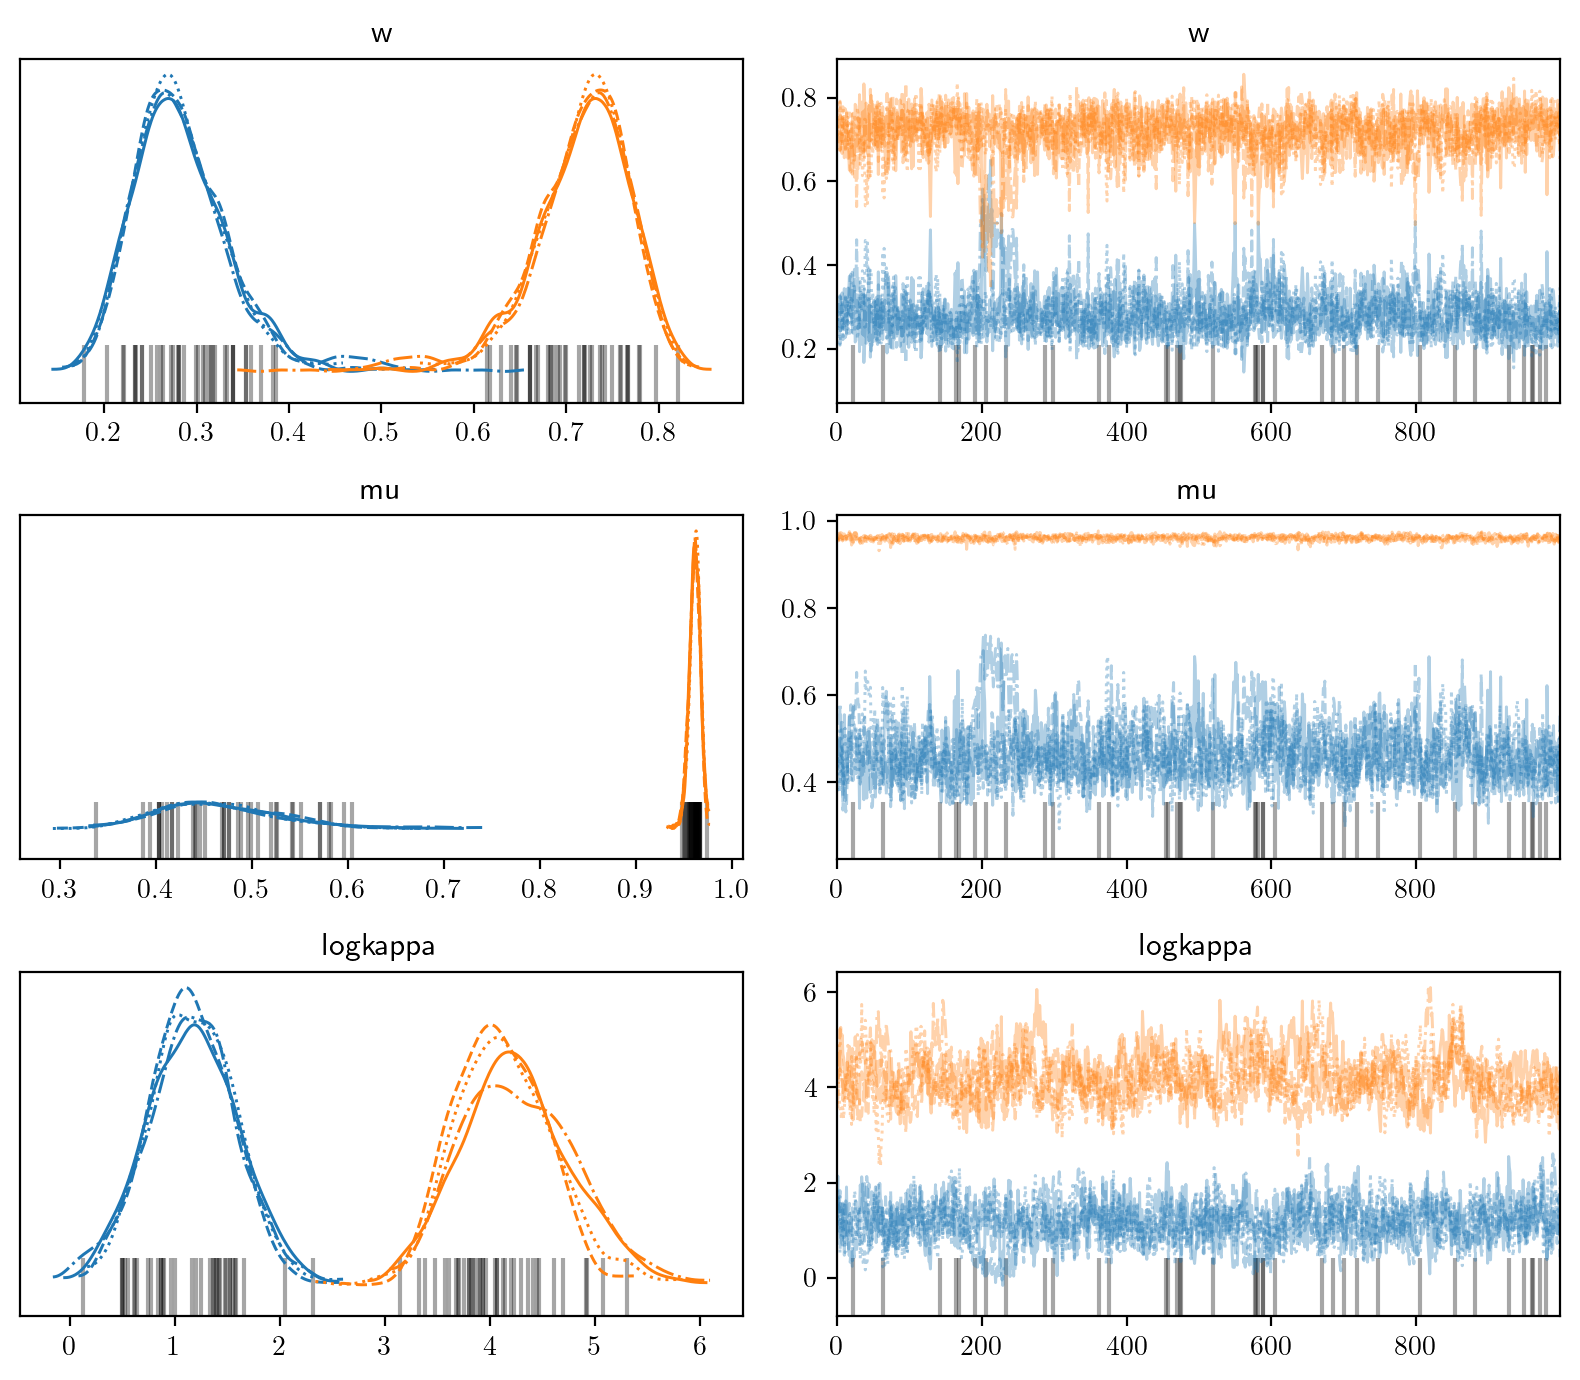

In [19]:
az.plot_trace(idata, var_names=['w','mu','logkappa'], figsize=(8,7))
plt.tight_layout()

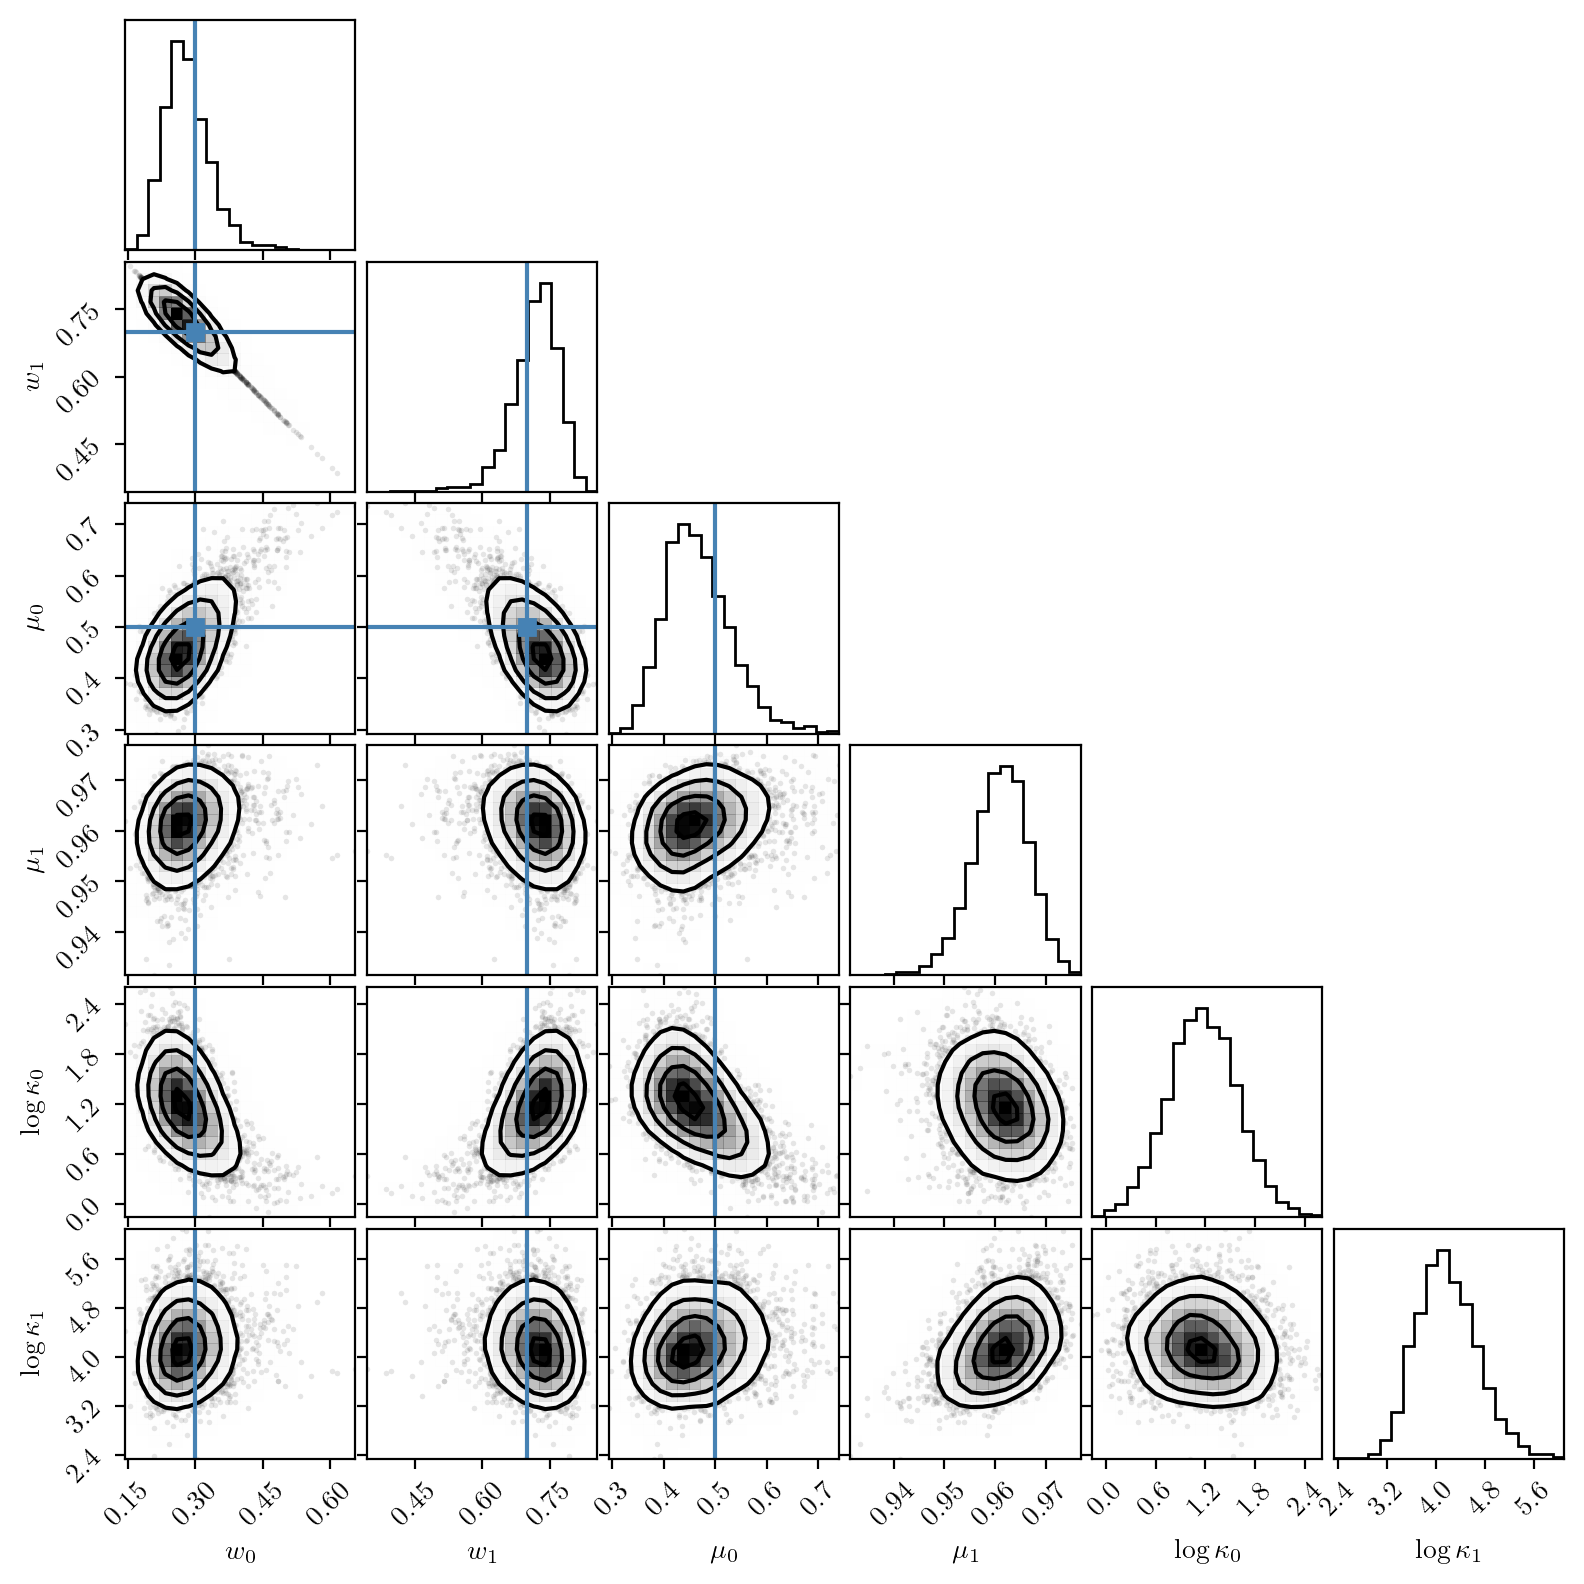

In [41]:
import corner
fig = corner.corner(idata, var_names=['w','mu','logkappa'], smooth=True, labelpad=0.05,
                    truths={'w': [0.3, 0.7], 'mu': [0.5, None], 'logkappa': [None, None]},
                    labels=[r'$w_0$',r'$w_1$',r'$\mu_0$',r'$\mu_1$',r'$\log{\kappa_0}$',r'$\log{\kappa_1}$']);
fig.set_size_inches(8,8)

We can now plot the $\cos{\psi}$ distribution draws from the posteriors.

In [23]:
from scipy.stats import beta
post = idata.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),4000))
for a in range(4):
    for b in range(1000):
        draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a[a,b,0], post.b[a,b,0])
                              +post.w[a,b,1].values*beta.pdf(x, post.a[a,b,1], post.b[a,b,1]))

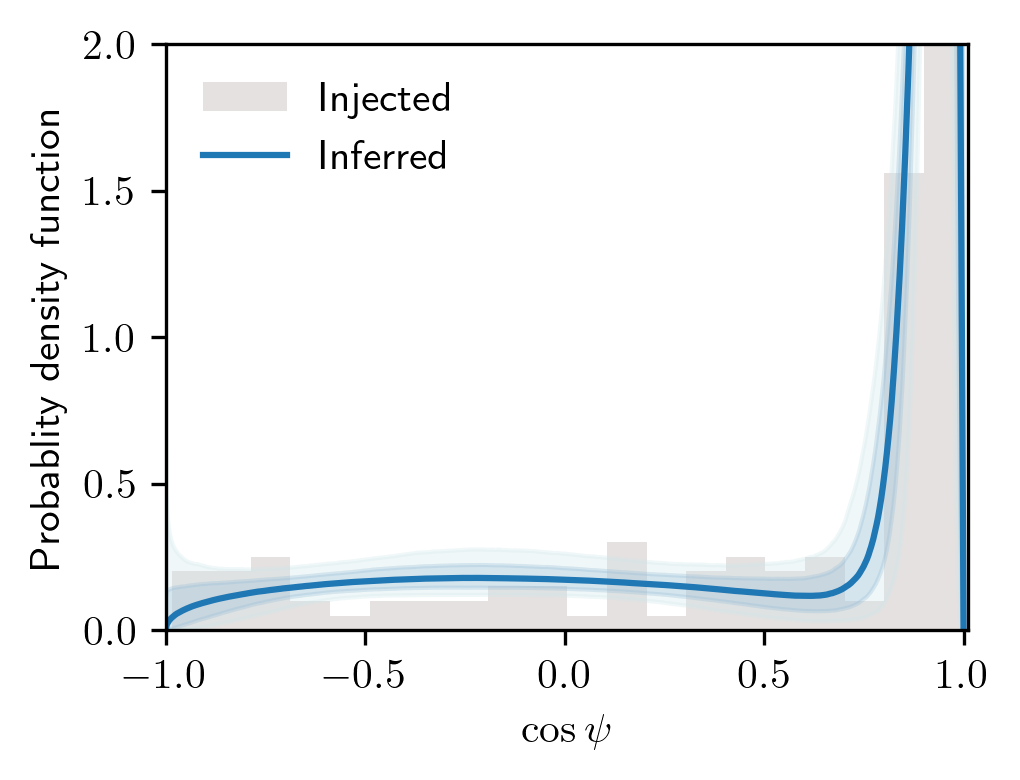

In [33]:
plt.figure(figsize=(3.5,2.7),dpi=150)

plt.hist(true_cosψ, color='#e5e1e0', bins=20, zorder=0, density=True, label='Injected')

q025, q16, q50, q84, q975 = np.percentile(draws, [2.5, 16, 50, 84, 97.5], axis=1)/2
plt.plot(2*x-1, q50, color='C0', label='Inferred')
plt.fill_between(2*x-1, q16, q84, alpha=0.3, color='#7dabd0')
plt.fill_between(2*x-1, q025, q975, alpha=0.3, color='#cfe7ea')

plt.ylim([0,2])
plt.xlim([-1,1.01])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.legend(framealpha=0)

plt.tight_layout()
plt.show()

### Case 2: Infer the $\psi$ distribution from $\lambda$, $i_\star$, and $i_{\rm orb}$

In this model, we work on the same data but now add $i_\star$ measurements obs_istar and err_istar.

Input:
- obs_lam, err_lam
- obs_istar, err_istar
- obs_iorb, err_iorb

Output:
- Inferred $\psi$ for each planet
- Inferred $\{w_0, w_1, \mu_0, \kappa_0, \mu_1, \kappa_1\}$ that describe the stellar obliquity $\psi$ distribution

In [34]:
with pm.Model() as model_istar:
    
    ncomps = 2

    # hyperprior
    w = pm.Dirichlet('w', np.ones(ncomps))

    if ncomps > 1:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps, 
                       transform=pm.distributions.transforms.Ordered(), 
                       initval=np.array([0.5,0.9]))
    else:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps)
        
    logκ = pm.Normal('logkappa', 3.0, shape=ncomps)
    κ = pm.Deterministic('kappa', pm.math.exp(logκ))
  
    a = pm.Deterministic('a', μ*κ)
    b = pm.Deterministic('b', (1-μ)*κ)
    
    # mixture cosψ distribution
    u = pm.Mixture('u', w=w, comp_dists=pm.Beta.dist(a,b, shape=(ncomps,)), shape=nsample)
    
    cosψ = pm.Deterministic('cosψ', 2*u-1)
    sinψ = pm.Deterministic('sinψ', at.sqrt(1-cosψ**2))
    
    # uniform θ prior
    θ = pm.Uniform('θ', lower=0, upper=np.pi, shape=nsample)
    sinθ = pm.Deterministic('sinθ', at.sin(θ))
    cosθ = pm.Deterministic('cosθ', at.cos(θ))
    
    # uniform cosiorb prior
    cosiorb = pm.Uniform('cosiorb', lower=0., upper=0.2, shape=nsample)
    iorb = pm.Deterministic('iorb', at.arccos(cosiorb))
    
    # find λ in terms of ψ, θ, and iorb
    λ = pm.Deterministic('λ', at.arctan2(sinψ*sinθ, cosψ*at.sin(iorb)-sinψ*cosθ*at.cos(iorb)))
    
    # find istar in terms of ψ, θ, and iorb
    cosistar = pm.Deterministic('cosistar', sinψ*cosθ*at.sin(iorb)+cosψ*at.cos(iorb))
    istar = pm.Deterministic('istar', at.arccos(cosistar))
    
    # logl for iorb; observed parameters obs_iorb and err_iorb
    logl_iorb = pm.Normal('logl_iorb', mu=iorb, sigma=err_iorb, observed=obs_iorb)
    
    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)    

    # logl for istar; observed parameters obs_istar and err_istar
    logl_istar = pm.Normal('logl_istar', mu=istar, sigma=err_istar, observed=obs_istar)
    
    idata_istar = pm.sample(nuts={'target_accept':0.99, 'max_treedepth':13}, random_seed=123) # 'step_scale':0.01

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kw

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 336 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
az.summary(idata_istar, var_names=['w','mu','logkappa'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w[0]         0.313  0.053   0.221    0.423      0.002    0.001    1047.0   
w[1]         0.687  0.053   0.577    0.779      0.002    0.001    1047.0   
mu[0]        0.501  0.065   0.390    0.627      0.002    0.002     912.0   
mu[1]        0.964  0.004   0.956    0.971      0.000    0.000    1612.0   
logkappa[0]  0.769  0.269   0.263    1.252      0.008    0.006    1066.0   
logkappa[1]  4.319  0.495   3.379    5.222      0.027    0.019     365.0   

             ess_tail  r_hat  
w[0]           1472.0   1.00  
w[1]           1472.0   1.00  
mu[0]           940.0   1.00  
mu[1]          2474.0   1.00  
logkappa[0]    1142.0   1.00  
logkappa[1]     508.0   1.01

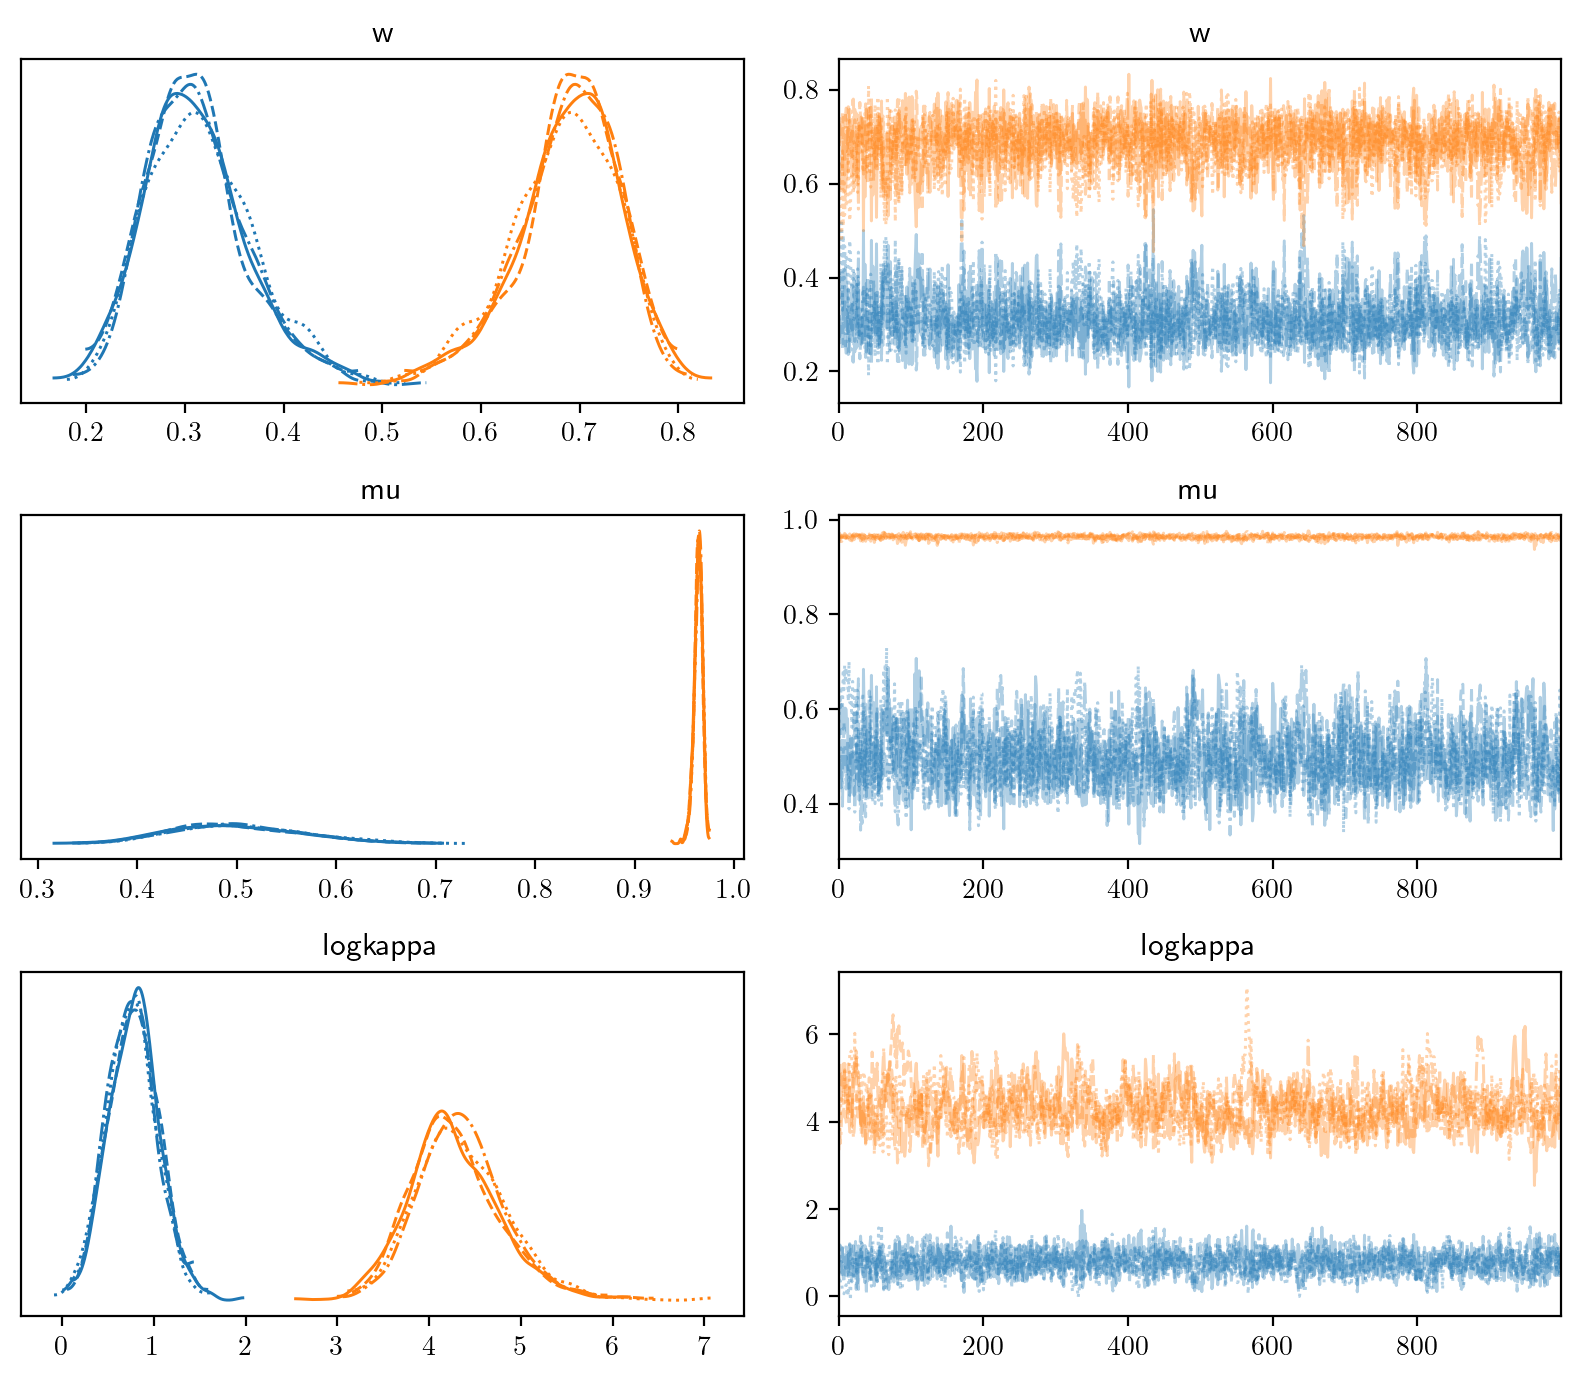

In [36]:
az.plot_trace(idata_istar, var_names=['w','mu','logkappa'], figsize=(8,7))
plt.tight_layout()

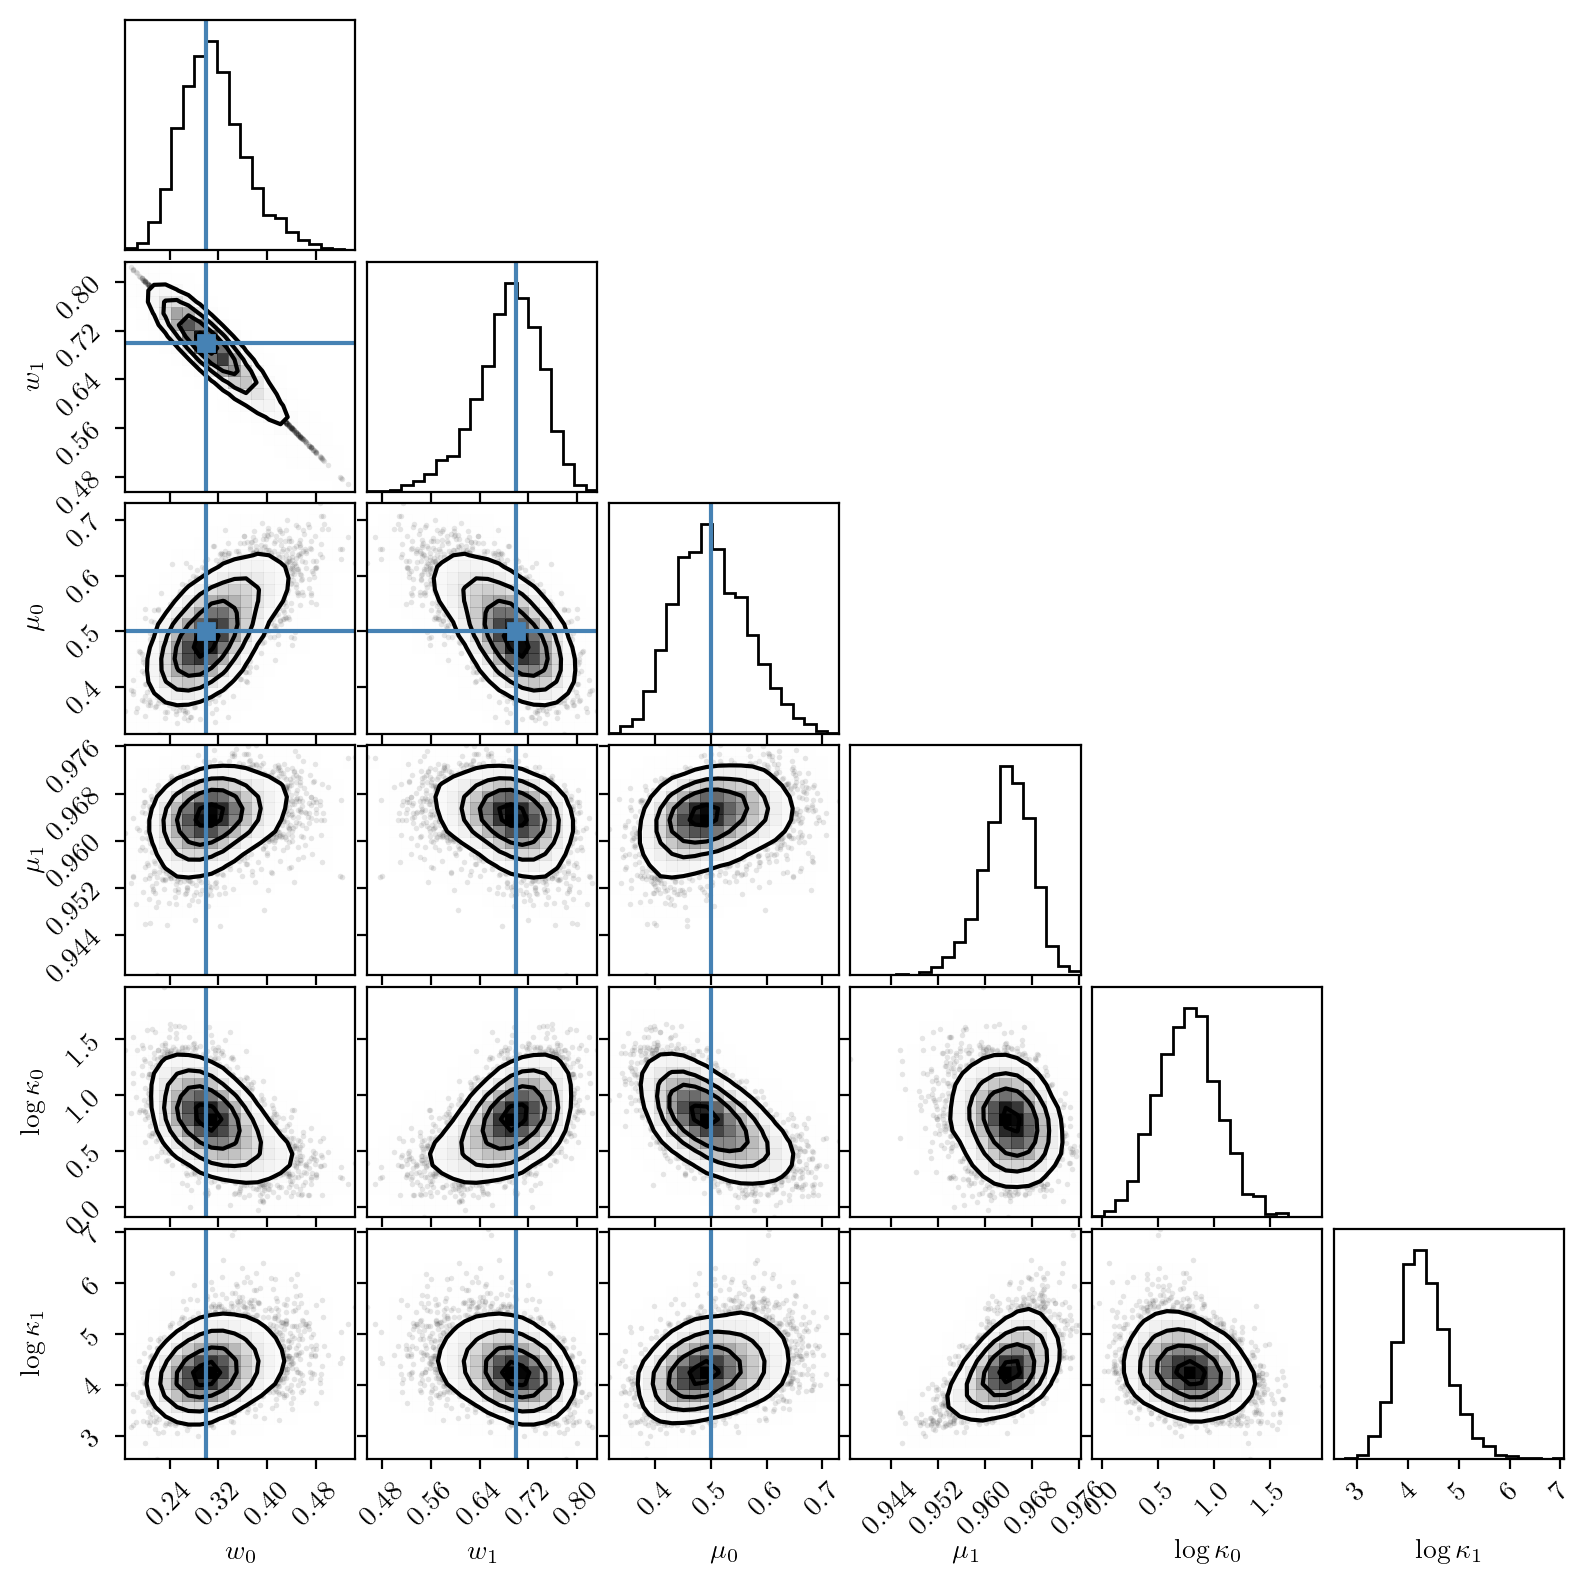

In [40]:
import corner
fig = corner.corner(idata_istar, var_names=['w','mu','logkappa'], smooth=True, labelpad=0.05,
                    truths={'w': [0.3, 0.7], 'mu': [0.5, None], 'logkappa': [None, None]},
                    labels=[r'$w_0$',r'$w_1$',r'$\mu_0$',r'$\mu_1$',r'$\log{\kappa_0}$',r'$\log{\kappa_1}$']);
fig.set_size_inches(8,8)

In [38]:
from scipy.stats import beta
post = idata_istar.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),4000))
for a in range(4):
    for b in range(1000):
        draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a[a,b,0], post.b[a,b,0])
                              +post.w[a,b,1].values*beta.pdf(x, post.a[a,b,1], post.b[a,b,1]))

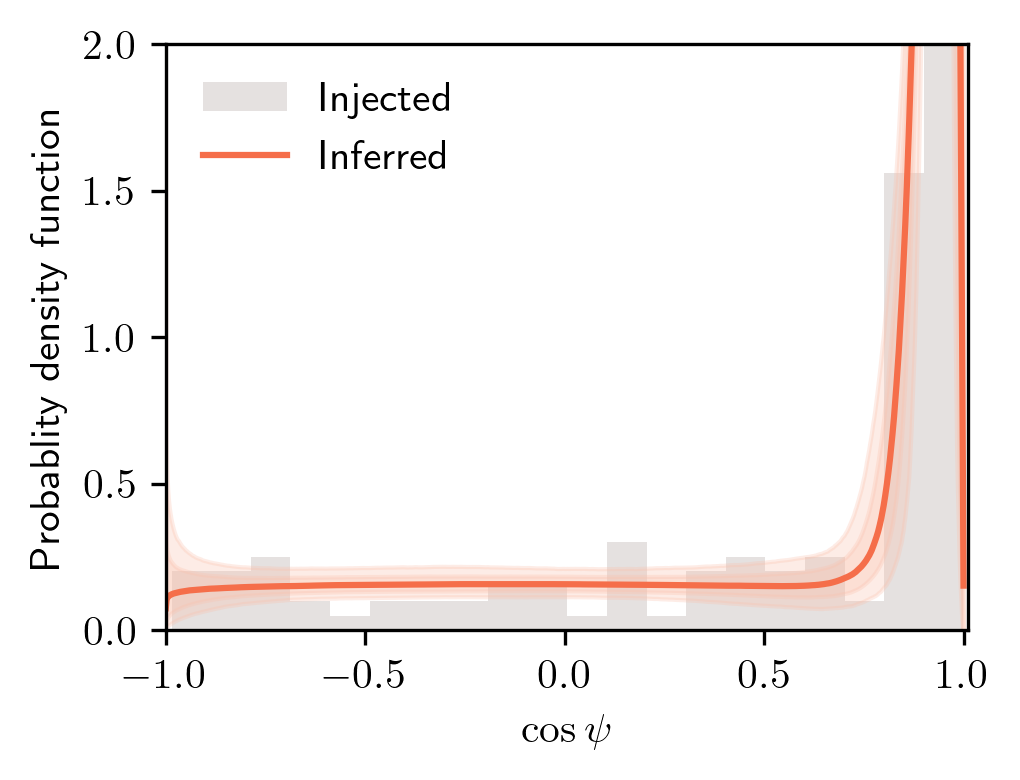

In [39]:
plt.figure(figsize=(3.5,2.7),dpi=150)

plt.hist(true_cosψ, color='#e5e1e0', bins=20, zorder=0, density=True, label='Injected')

q025, q16, q50, q84, q975 = np.percentile(draws, [2.5, 16, 50, 84, 97.5], axis=1)/2
plt.plot(2*x-1, q50, color='#f56e4a', label='Inferred')
plt.fill_between(2*x-1, q16, q84, alpha=0.3, color='#fbc1ad')
plt.fill_between(2*x-1, q025, q975, alpha=0.3, color='#fbc1ad')

plt.ylim([0,2])
plt.xlim([-1,1.01])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.legend(framealpha=0)

plt.tight_layout()
plt.show()

### Case 3: Infer the $\psi$ distribution from $\lambda$, $R_\star$, $P_{\rm rot}$, and $v\sin{i_\star}$

Similar to Case 2, but instead of using obs_istar and err_istar, we infer $i_\star$ from $R_\star$, $P_{\rm rot}$, and $v\sin{i_\star}$ using the rotational modulation method.

Input:
- obs_lam, err_lam
- obs_Rstar, err_Rstar
- obs_Prot, err_Prot
- obs_vsini, err_vsini
- obs_iorb, err_iorb

Output:
- Inferred $\psi$ for each planet
- Inferred $\{w_0, w_1, \mu_0, \kappa_0, \mu_1, \kappa_1\}$ that describe the stellar obliquity $\psi$ distribution

In [42]:
with pm.Model() as model_rot:
    
    ncomps = 2

    # hyperprior
    w = pm.Dirichlet('w', np.ones(ncomps))

    if ncomps > 1:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps, 
                       transform=pm.distributions.transforms.Ordered(), 
                       initval=np.array([0.5,0.9]))
    else:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps)
        
    logκ = pm.Normal('logkappa', 3.0, shape=ncomps)
    κ = pm.Deterministic('kappa', pm.math.exp(logκ))
  
    a = pm.Deterministic('a', μ*κ)
    b = pm.Deterministic('b', (1-μ)*κ)
    
    # mixture cosψ distribution
    u = pm.Mixture('u', w=w, comp_dists=pm.Beta.dist(a,b, shape=(ncomps,)), shape=nsample)
    
    cosψ = pm.Deterministic('cosψ', 2*u-1)
    sinψ = pm.Deterministic('sinψ', at.sqrt(1-cosψ**2))
    
    # uniform θ prior
    θ = pm.Uniform('θ', lower=0, upper=np.pi, shape=nsample)
    sinθ = pm.Deterministic('sinθ', at.sin(θ))
    cosθ = pm.Deterministic('cosθ', at.cos(θ))
    
    # uniform cosiorb prior
    cosiorb = pm.Uniform('cosiorb', lower=0., upper=0.2, shape=nsample)
    iorb = pm.Deterministic('iorb', at.arccos(cosiorb))
    
    # find λ in terms of ψ, θ, and iorb
    λ = pm.Deterministic('λ', at.arctan2(sinψ*sinθ, cosψ*at.sin(iorb)-sinψ*cosθ*at.cos(iorb)))
    
    # find istar in terms of ψ, θ, and iorb
    cosistar = pm.Deterministic('cosistar', sinψ*cosθ*at.sin(iorb)+cosψ*at.cos(iorb))
    istar = pm.Deterministic('istar', at.arccos(cosistar))

    # find vsini from Rstar, Prot, and istar
    Rstar = pm.Normal('Rstar', mu=obs_Rstar, sigma=err_Rstar)  # solar radii
    Prot = pm.Normal('Prot', mu=obs_Prot, sigma=err_Prot)  # days
    
    vrot = pm.Deterministic('vrot', 2*np.pi*Rstar/Prot*8.052) # normalization (1 solar radii)/(1 day) in km/s
    vsini = pm.Deterministic('vsini', vrot*at.sin(istar))
    
    # logl for iorb; observed parameters obs_iorb and err_iorb
    logl_iorb = pm.Normal('logl_iorb', mu=iorb, sigma=err_iorb, observed=obs_iorb)
    
    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)
    
    # logl for vsini; observed parameters obs_vsini and err_vsini
    logl_vsini = pm.Normal('logl_vsini', mu=vsini, sigma=err_vsini, observed=obs_vsini)
    
    idata_rot = pm.sample(nuts={'target_accept':0.99, 'max_treedepth':13}, random_seed=123) # 'step_scale':0.01

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/envs/pymc5/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:776: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kw

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 364 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [43]:
az.summary(idata_rot, var_names=['w','mu','logkappa'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w[0]         0.260  0.045   0.184    0.347      0.002    0.002     626.0   
w[1]         0.740  0.045   0.653    0.816      0.002    0.002     626.0   
mu[0]        0.429  0.065   0.321    0.558      0.004    0.003     443.0   
mu[1]        0.958  0.005   0.949    0.967      0.000    0.000     944.0   
logkappa[0]  1.101  0.349   0.443    1.730      0.015    0.011     575.0   
logkappa[1]  4.215  0.484   3.311    5.096      0.045    0.032     134.0   

             ess_tail  r_hat  
w[0]            340.0   1.01  
w[1]            340.0   1.01  
mu[0]           299.0   1.02  
mu[1]          2103.0   1.01  
logkappa[0]     294.0   1.01  
logkappa[1]     297.0   1.04

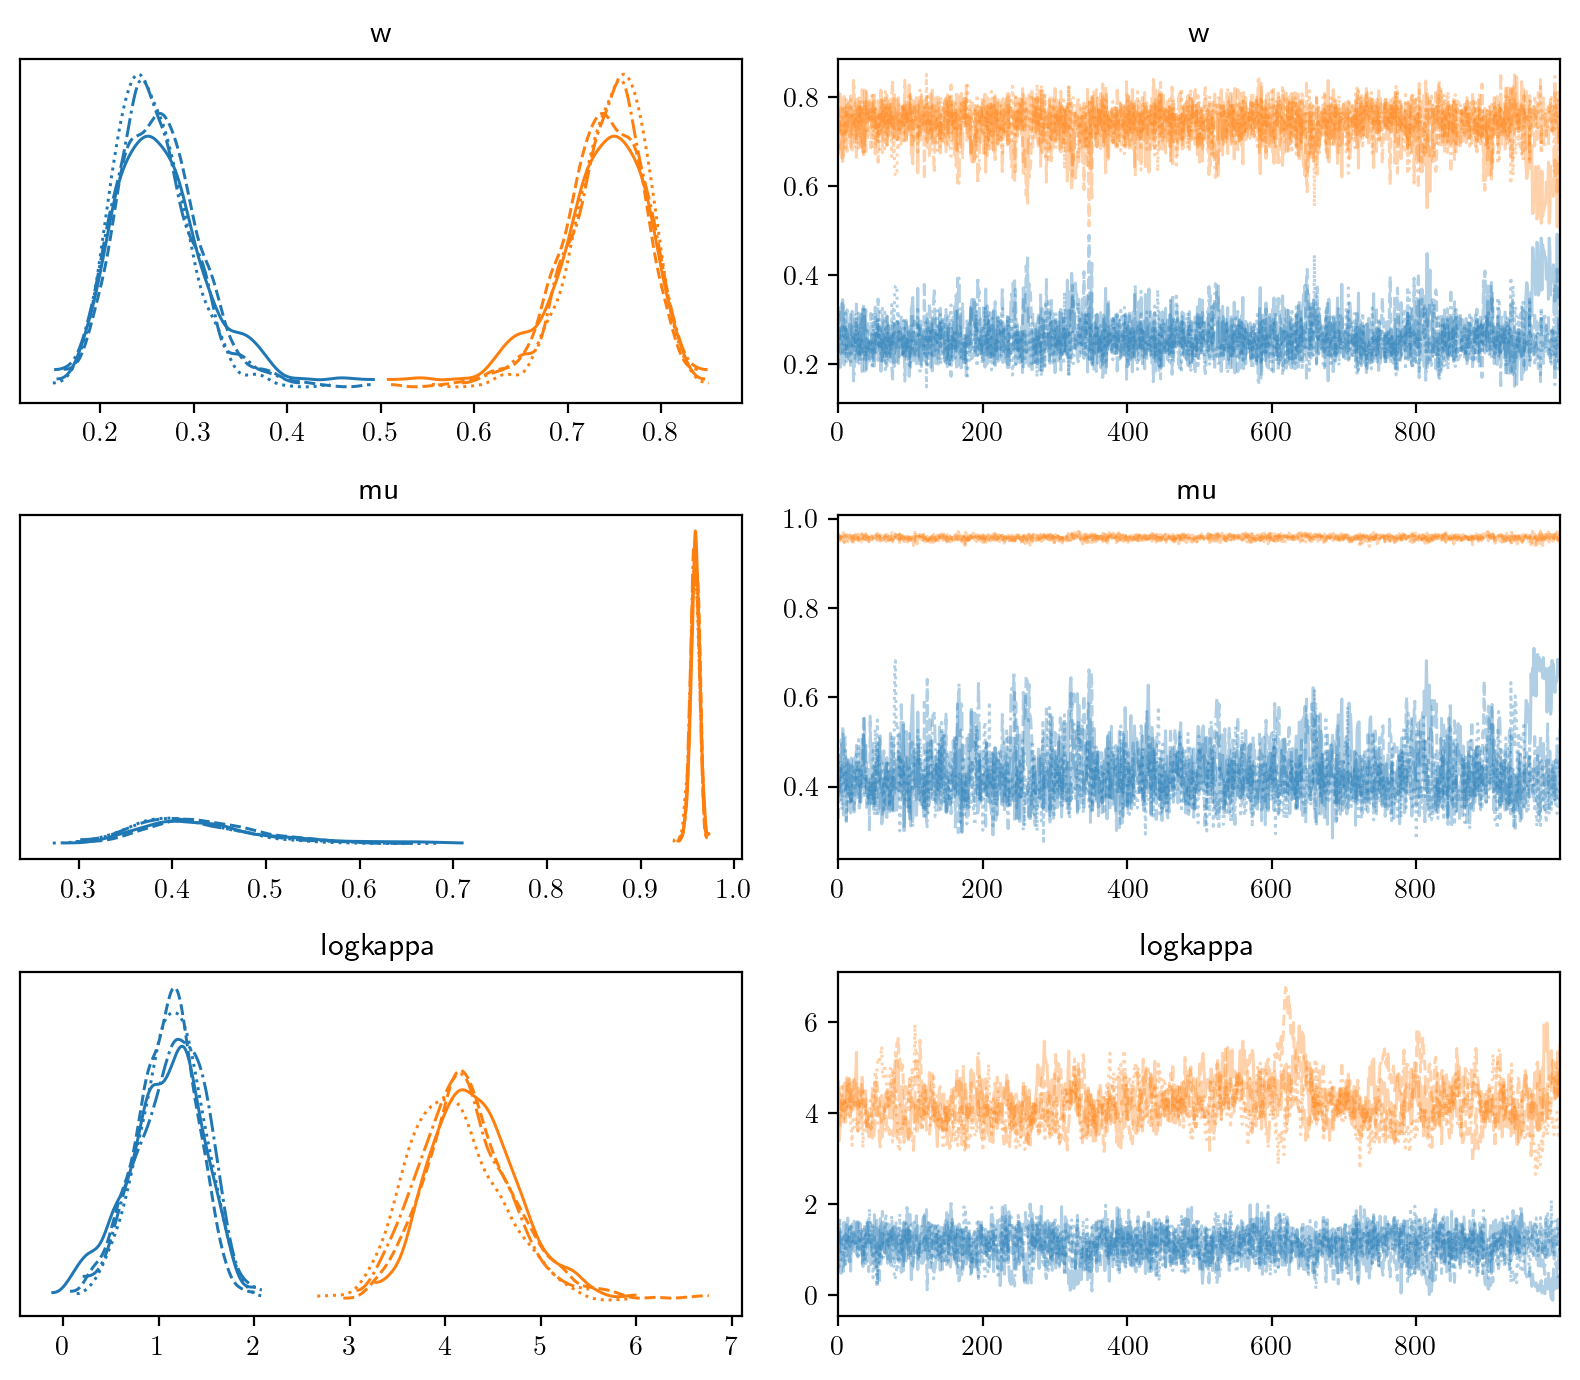

In [44]:
az.plot_trace(idata_rot, var_names=['w','mu','logkappa'], figsize=(8,7))
plt.tight_layout()

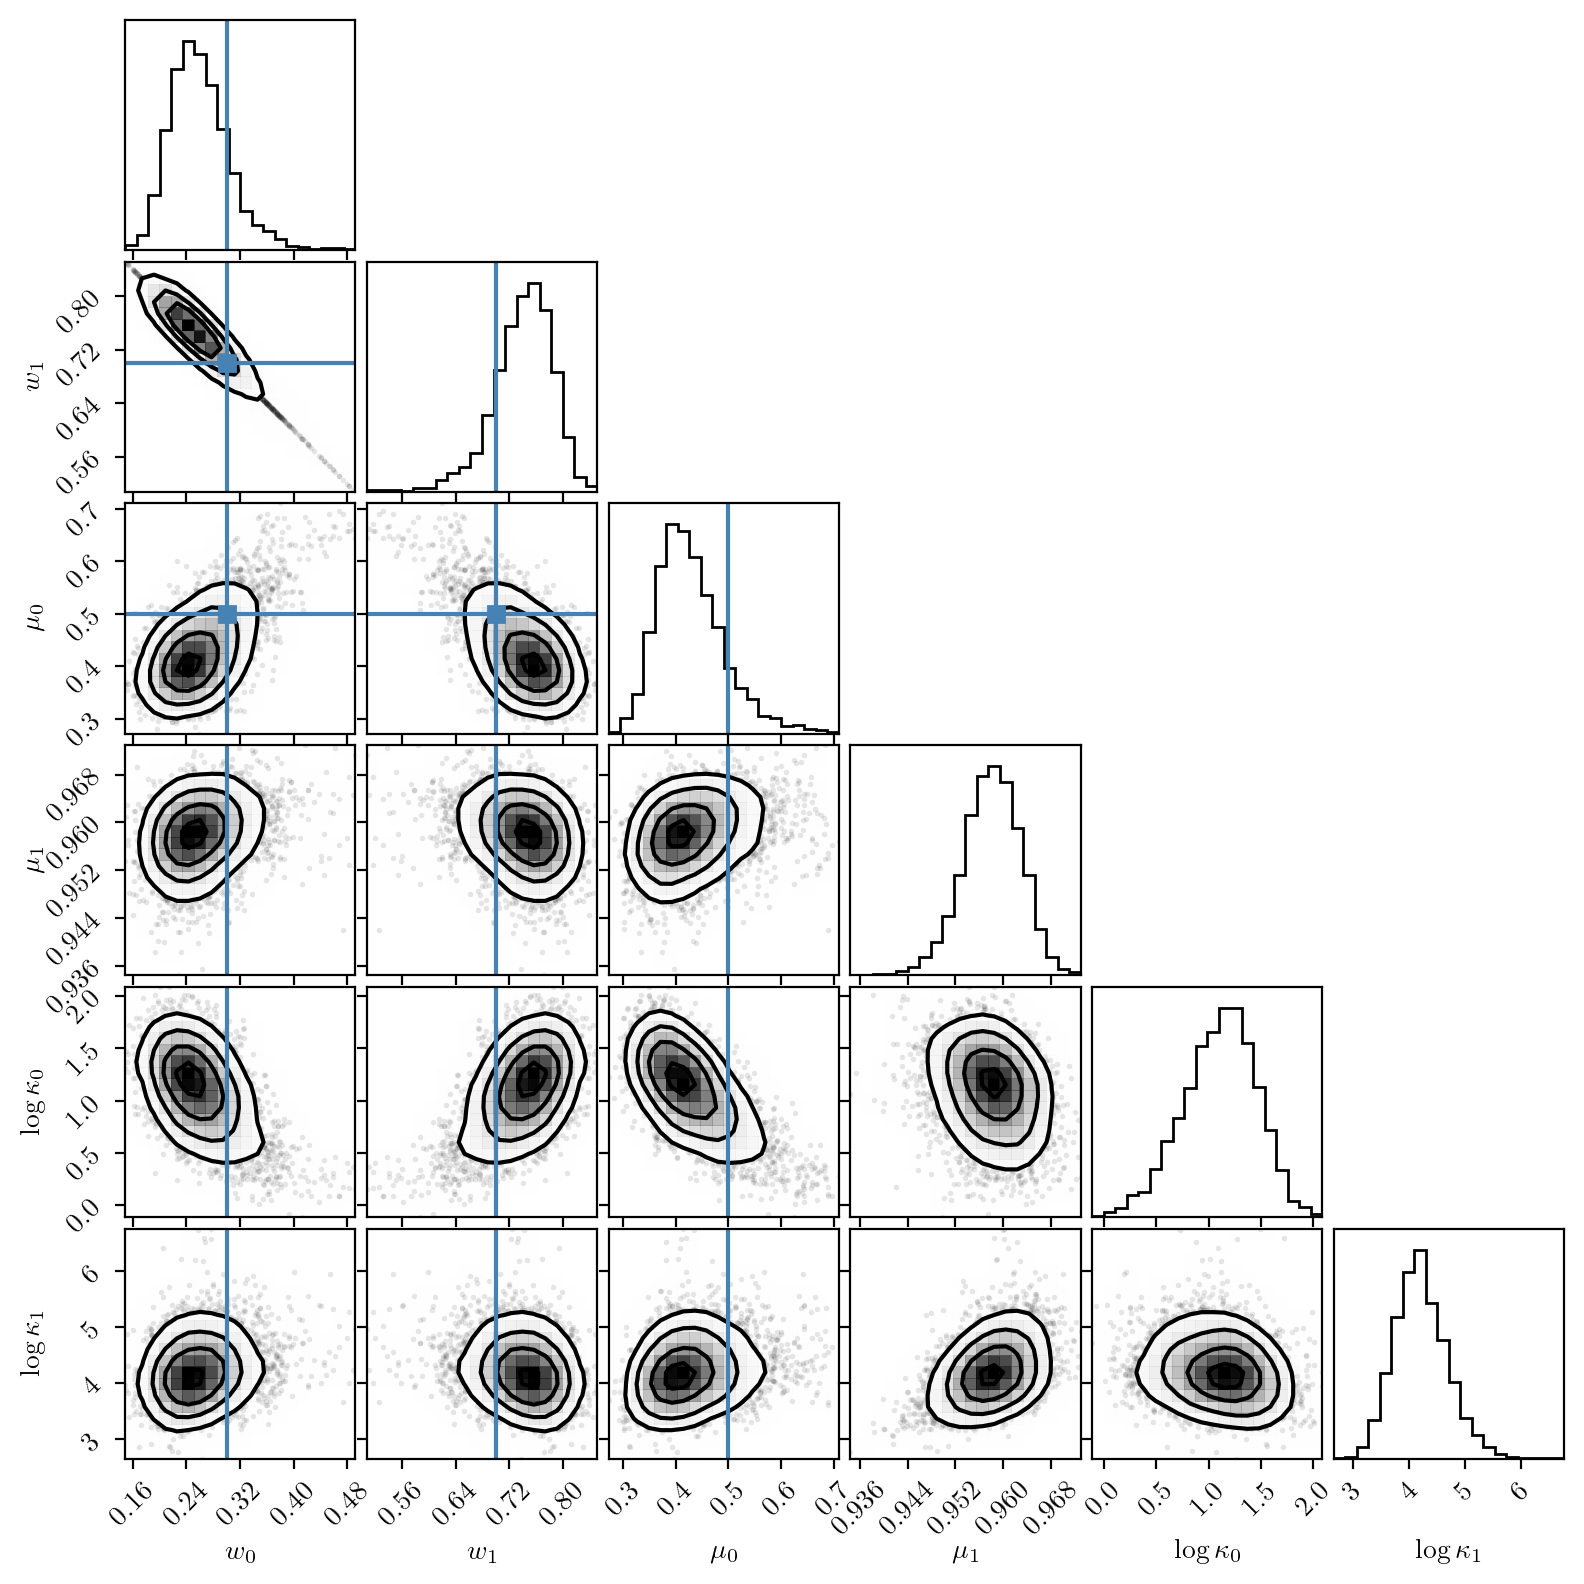

In [45]:
import corner
fig = corner.corner(idata_rot, var_names=['w','mu','logkappa'], smooth=True, labelpad=0.05,
                    truths={'w': [0.3, 0.7], 'mu': [0.5, None], 'logkappa': [None, None]},
                    labels=[r'$w_0$',r'$w_1$',r'$\mu_0$',r'$\mu_1$',r'$\log{\kappa_0}$',r'$\log{\kappa_1}$']);
fig.set_size_inches(8,8)

In [46]:
from scipy.stats import beta
post = idata_rot.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),4000))
for a in range(4):
    for b in range(1000):
        draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a[a,b,0], post.b[a,b,0])
                              +post.w[a,b,1].values*beta.pdf(x, post.a[a,b,1], post.b[a,b,1]))

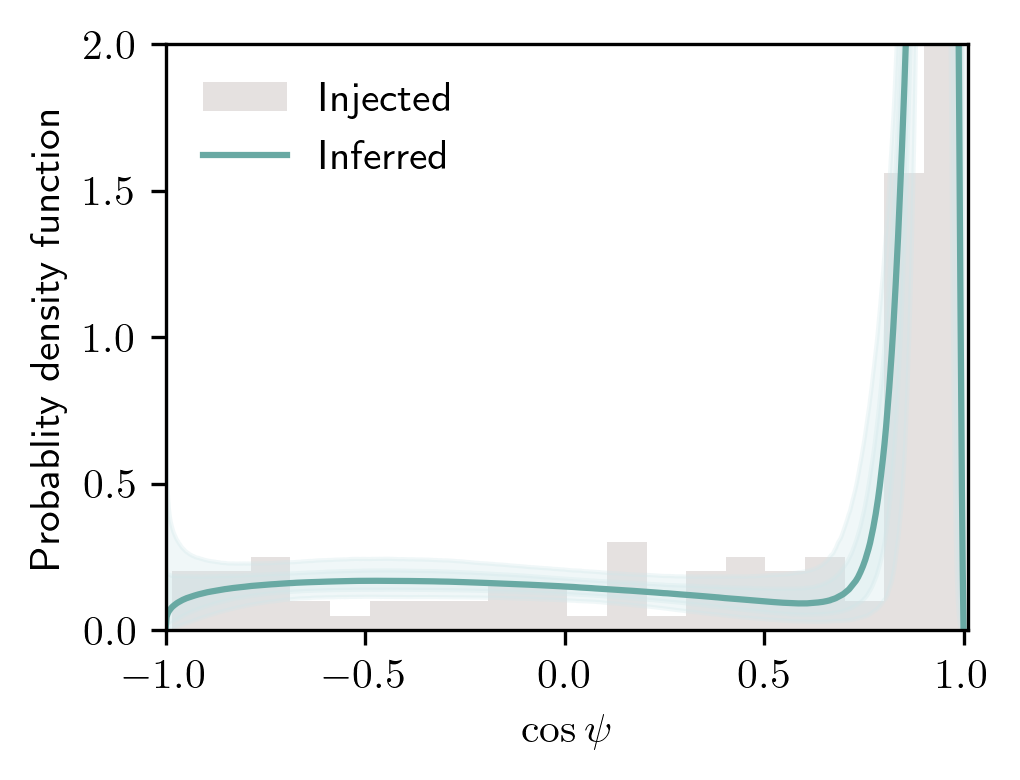

In [47]:
plt.figure(figsize=(3.5,2.7),dpi=150)

plt.hist(true_cosψ, color='#e5e1e0', bins=20, zorder=0, density=True, label='Injected')

q025, q16, q50, q84, q975 = np.percentile(draws, [2.5, 16, 50, 84, 97.5], axis=1)/2
plt.plot(2*x-1, q50, color='#69a9a3', label='Inferred')
plt.fill_between(2*x-1, q16, q84, alpha=0.3, color='#cfe7ea')
plt.fill_between(2*x-1, q025, q975, alpha=0.3, color='#cfe7ea')

plt.ylim([0,2])
plt.xlim([-1,1.01])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.legend(framealpha=0)

plt.tight_layout()
plt.show()